In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os
import re


import pickle
from etcpy import etc
from etcpy import tempDep
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params_modified.csv'),index_col=0)
df = etc.calculate_thermal_params(params)

dfae_batch = data[4].set_index('Ts').rename_axis(None)

In [3]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    match = re.compile('usage_prot_*', re.IGNORECASE)
    for react in mae.reactions:
        if match.match(react.id) and react.lower_bound != -1000:
            ori_lb = react.lower_bound
            react.lower_bound = ori_lb*2.125


    mae.reactions.EX_glc__D_e.lower_bound = -100
    mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    #mae.medium['EX_glc__D_e'] = 100
    
    try: 
        rae, gae, oae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    rexp = dfae_batch['r'].values
    #print(rae)
    #print(abs(rae - dfae_batch['r'].values))
    print('r2_batch:',r2_score(rexp,rae))
    print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae)}, r2_score(rexp,rae)

6
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29
NGAM is: 3.23


/home/aditi/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Failed to solve the problem
Growth at  9.205600000000004 is:  0
NGAM is: 3.23


/home/aditi/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Failed to solve the problem
Growth at  10.953000000000031 is:  0
NGAM is: 3.23
Growth at  12.414300000000026 is:  0.0
NGAM is: 3.23
Growth at  13.48380000000003 is:  0.0
NGAM is: 3.23
Growth at  14.873800000000017 is:  0.0
NGAM is: 3.23
Growth at  15.905700000000024 is:  0.0
NGAM is: 3.23
Growth at  17.012100000000032 is:  0.0
NGAM is: 3.23
Growth at  18.117400000000032 is:  0.0
NGAM is: 3.23
Growth at  19.256100000000004 is:  8.69076924863934e-07
NGAM is: 3.23
Growth at  20.217100000000016 is:  3.19877834798963e-06
NGAM is: 3.23
Growth at  21.14330000000001 is:  1.308917565606152e-05
NGAM is: 3.23
Growth at  22.353400000000022 is:  3.911741039236048e-05
NGAM is: 3.23
Growth at  24.41900000000004 is:  0.0002403787641391384
NGAM is: 3.477026378713294
Growth at  25.737300000000005 is:  0.0007388407555844931
NGAM is: 3.77966481688261
Growth at  26.697100000000034 is:  0.001647251926984382
NGAM is: 4.172801131119886
Growth at  28.05060000000003 is:  0.0050014592319225955
NGAM is: 4.4485947

/home/aditi/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Failed to solve the problem
Growth at  9.205600000000004 is:  0
NGAM is: 3.23
Growth at  10.953000000000031 is:  0.002745108716444554
NGAM is: 3.23
Growth at  12.414300000000026 is:  0.019295908273753756
NGAM is: 3.23
Growth at  13.48380000000003 is:  0.034335573174677274
NGAM is: 3.23
Growth at  14.873800000000017 is:  0.05542541659872501
NGAM is: 3.23
Growth at  15.905700000000024 is:  0.0696138683854374
NGAM is: 3.23
Growth at  17.012100000000032 is:  0.08805028976623255
NGAM is: 3.23
Growth at  18.117400000000032 is:  0.11027813066871482
NGAM is: 3.23
Growth at  19.256100000000004 is:  0.13768976245220174
NGAM is: 3.23
Growth at  20.217100000000016 is:  0.1647857092891219
NGAM is: 3.23
Growth at  21.14330000000001 is:  0.19464776276636675
NGAM is: 3.23
Growth at  22.353400000000022 is:  0.23964729482632918
NGAM is: 3.23
Growth at  24.41900000000004 is:  0.3334375204289461
NGAM is: 3.477026378713294
Growth at  25.737300000000005 is:  0.4051559043724682
NGAM is: 3.77966481688261
Grow

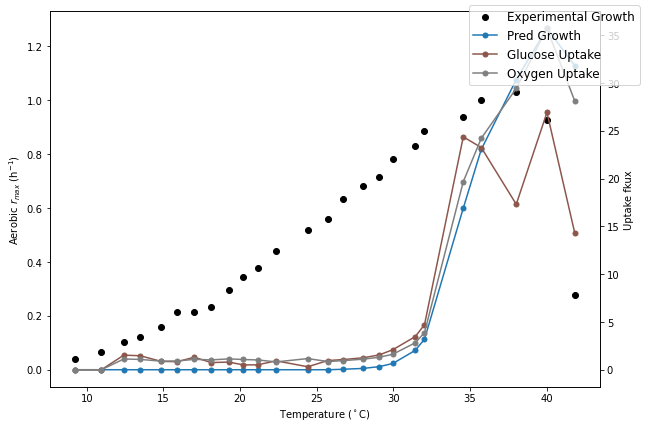

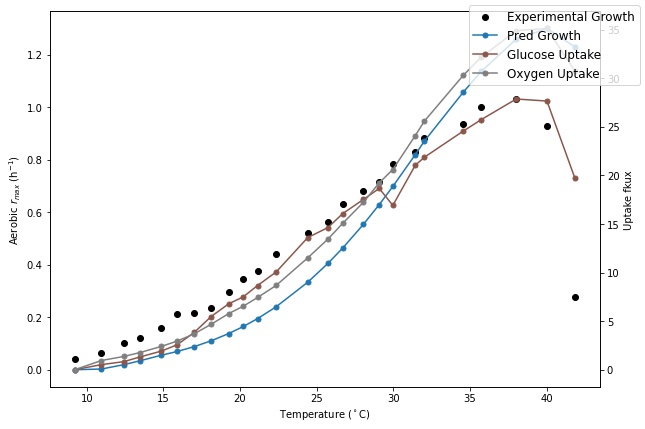

In [4]:
i = 6
S = 0
score = 0.4
while i<8:
    print(i)
    if i == 1:
        params = tempDep.sample_data_uncertainty_with_constraint_increasing_topt(params, ['Topt', 'dCpt'])
        rae, score = aerobic(params)
        if score > S:
            S = score
    elif score < S:
        params = tempDep.sample_data_uncertainty_with_constraint_small_increasing_topt(params, ['Topt', 'dCpt'])
        rae, score = aerobic(params)
        if score > S:
            S = score
    else:
        newParams = tempDep.sample_data_uncertainty_with_constraint_random_topt(params, ['Tm'])
        rae, score = aerobic(newParams)
        if score > S:
            S = score
    fig, ax1 = plt.subplots(figsize=(9, 6))
    ax2 = ax1.twinx()

    ax1.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
    ax1.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')

    ax2.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose Uptake', color='tab:brown')
    ax2.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen Uptake', color='tab:gray')

    ax1.set_xlabel("Temperature ($^\circ$C)")
    ax1.set_ylabel("Aerobic $r_{max}$ (h$^{-1}$)")

    ax2.set_ylabel("Uptake fkux")

    fig.legend(fontsize=12)
    fig.tight_layout()
    fig.savefig("../results/IncToptRandTmLowTemp" + str(i) + ".pdf")
    i = i +1

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source,TmTag
P77467,313.044308,10,262,328.717325,7.588735,NaN,-3423.938480,1000,predicted,Mean
P76077,316.516810,10,309,328.717325,7.588735,NaN,-3773.237600,1000,predicted,Mean
P76078,319.640946,10,95,328.717325,7.588735,NaN,-4512.364486,1000,BullShit,Mean
P76079,315.127809,10,248,328.717325,7.588735,NaN,-2515.871424,1000,predicted,Mean
P76081,319.640946,10,356,328.717325,7.588735,NaN,-4365.163721,1000,BullShit,Mean
...,...,...,...,...,...,...,...,...,...,...
P0AG80,318.042974,10,438,329.166303,4.070000,330.45,-5482.741614,1000,predicted,Exp
P77718,310.808587,10,482,319.125751,4.070000,320.15,-2367.093258,1000,predicted,Exp
P0A6D5,314.447142,10,288,328.762604,7.710000,NaN,-3284.129164,1000,predicted,Mean
standard,318.686419,10,272,328.762604,7.710000,NaN,-3965.023061,1000,BullShit,Mean
